In [1]:
import numpy as np
from collections import OrderedDict
import warnings

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn.functional as F

from matplotlib import pyplot as plt
import cv2

In [2]:
# Setup torch device, using GPU if its available 
# Training with the CPU on my laptop is very very slow, so using a GPU with Google colab is preferred
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    warnings.warn("It is recommended to use train on a GPU, perhaps through Google colab, for performance")
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


# Setup
To begin, we will start by importing the data. The dataset used in this project was found on Kaggle ([link](https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset)) and contains labelled images of chess pieces, including both digital and real images. This is good since I would like my model to have the ability to classify images of chess pieces from online games and well as live over-the-board chess games.

The code below imports the data from a chess_pieces directory in the same directory and this project, and separates it into training and validation data. It then creates PyTorch DataLoader objects from the data to be used later on. At this point, this is mostly "boilerplate" PyTorch.

## Transforming the Data
Some transformations were applied to the data before proceeding which seek to improve the model's ability to classify the images, and make things easier later on. Here I have chosen to apply the RandomHorizontalFlip and RandomRotation transforms. The ToTensor transform is just necessary for using PyTorch.

In [3]:
# Define transformations for training
input_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p = 0.4),
    transforms.RandomRotation(30),
    #transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5 ,0.5))    
])

In [36]:
! rm -rf chess_pieces/.ipynb_checkpoints/

In [37]:
# Load in the dataset
dataset_path = "/content/chess_pieces"
dataset = ImageFolder(dataset_path, transform=input_transforms)

train_data, val_data = torch.utils.data.random_split(
    dataset,
    [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)]
)

val_data, test_data = torch.utils.data.random_split(
    val_data,
    [int(len(val_data)*0.8), len(val_data) - int(len(val_data)*0.8)]
)

train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = True)
test_loader_ordered = DataLoader(test_data, batch_size = 1, shuffle = False)

# Defining a Model
Throughout our machine learning studies this quarter, we have not discussed deep learning, seeing as that is the topic of next quarter, however, in order to obtain reasonable results for a wide range of chess pieces, I have decided to use a convolutional neural network (CNN) for the model. This is because CNNs are notoriously good at classifying images and although we didn't learn much about them, many of the topics we did learn about still apply. 

To implement a CNN in PyTorch, we define a Python class that inherits from the nn.Module class. In this case, I have chosen to use the resnet50 model from the torchvision library. Although the mathematics behind this model (a residual neural network, which is a special case of a convolutional neural network) is beyond the scope of my understanding and our EE475 course, I have chosen to use it since implementing it with PyTorch was no more difficult that using another type of model, and residual neural networks have shown to be extremely good at classifying images. 

In [38]:
# Define a neural network as a class that inherits from the torch.nn.Module class 
class ChessCNN(nn.Module):
    def __init__(self):
        super(ChessCNN, self).__init__()

        # use ResNet, a deep neural network model, which is particularly good for image classification
        self.model = torchvision.models.resnet50(pretrained = True)

        for parameter in self.model.parameters():
            parameter.requires_grad = False

        # Define the model of each layer TODO: is this correct?
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 1000),
            nn.ReLU(),
            nn.Linear(1000, 5)
        )

    # forward propogation step
    def forward(self, x):
        x = self.model(x)
        return x

## Defining Training Parameters
The model is first instantiated for later use, then we define several parameters like the learning rate, number of iterations, the optimizer that we will use, and the loss function. 

**Learning Rate**

Here we set the learning rate to 0.00001. This was chosen after testing several learning rates both higher and lower. Higher learning rates result in faster training, however the loss oscillates or doesn't reach as small a value. An even smaller learning rate may be better, however I have access to only a limited amount of computing power (GPU access through Google Colab) so this learning rate is sufficient for this project.

**Number of iterations**
The number of iterations was chosen mostly because of time considerations but also and you can see from the output of the training step later on, after several hundred iterations, there are very few new best weights that are found that make the loss function any smaller. 

**Optimizer**



In [39]:
model = ChessCNN() # instantiate the neural net class
# learning_rate = 0.00001 # define the learning rate
learning_rate = 0.001
max_its = 1000 

# Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.001)
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.01)

# Define the loss function
loss_func = nn.CrossEntropyLoss() # use cross entropy loss function
min_loss = np.inf
model.to(device) # set model to use the appropriate defice (GPU or CPU)

ChessCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [40]:
def train(model, max_its, min_loss):
    for step in range(max_its):
        training_loss = 0
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            yhat = model(images)
            loss = loss_func(yhat, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            
            del images, labels
            torch.cuda.empty_cache()
            

        valid_loss = 0
        valid_accuracy = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                yhat = model(images)
                loss = loss_func(yhat, labels)
                valid_loss += loss.item()
                yhat = nn.Softmax(dim = 1)(yhat)
                top_p, top_class = yhat.topk(1, dim = 1)
                num_correct = top_class == labels.view(-1,1)
                valid_accuracy += num_correct.sum().item()

                del(images)
                del(labels)
                torch.cuda.empty_cache()

        # print("Step: {} \tTraining loss: {:.4f} \tValidation loss: {:.4f} \tAccuracy: {:.2f}%".format(step, training_loss, valid_loss, (valid_accuracy/len(val_data))*100))
        print(f"Step: {step} \tTraining loss: {training_loss:.4f} \tValidation loss: {valid_loss:.4f} \tAccuracy: {valid_accuracy/len(val_data)*100:.2f}%")

        # whenever a new minimum loss for the model is found replace the previous best model
        if valid_loss <= min_loss:
            print(f"New minumum loss found! = {valid_loss:.4f}\tSaving model...")
            torch.save(model.state_dict(), "trained_model.pt")
            min_loss = valid_loss # set new minumum loss

# Training
Running the cell below will begin the training process. This can be very slow, especially on an average CPU. Therefore, to train the model I have chosen to use Google Colab which offers free (but limited) GPU usage.

In [8]:
train(model, max_its, min_loss)

Step: 0 	Training loss: 52.5991 	Validation loss: 11.1866 	Accuracy: 19.23%
New minumum loss found! = 11.1866	Saving model...
Step: 1 	Training loss: 52.0676 	Validation loss: 11.0467 	Accuracy: 23.08%
New minumum loss found! = 11.0467	Saving model...
Step: 2 	Training loss: 51.5682 	Validation loss: 10.9403 	Accuracy: 24.04%
New minumum loss found! = 10.9403	Saving model...
Step: 3 	Training loss: 51.3615 	Validation loss: 11.0087 	Accuracy: 23.08%
Step: 4 	Training loss: 51.0128 	Validation loss: 10.9905 	Accuracy: 24.04%
Step: 5 	Training loss: 50.5236 	Validation loss: 10.8132 	Accuracy: 23.08%
New minumum loss found! = 10.8132	Saving model...
Step: 6 	Training loss: 50.4258 	Validation loss: 10.8142 	Accuracy: 26.92%
Step: 7 	Training loss: 50.0904 	Validation loss: 10.7325 	Accuracy: 30.77%
New minumum loss found! = 10.7325	Saving model...
Step: 8 	Training loss: 50.0430 	Validation loss: 10.6826 	Accuracy: 33.65%
New minumum loss found! = 10.6826	Saving model...
Step: 9 	Trainin

KeyboardInterrupt: ignored

In [43]:
total_correct = 0
count = 0
classes = dataset.classes
model.load_state_dict(torch.load('./trained_model.pt'))
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        yhat = model(images)
        yhat = nn.Softmax(dim = 1)(yhat)
        top_p, top_class = yhat.topk(1, dim = 1)
        eq = top_class == labels.view(-1, 1)
        # print(classes[top_class.item()])
        total_correct += eq.sum().item()
        
        if count % 1 == 0:
            print("Prediction: {}\t Confidence: {:.2f}%\t Actual label: {}".format(classes[top_class.item()], top_p.item() * 100, classes[labels.item()]))
        else:
            print(f"count%1 = {count % 1}")
        count += 1

print("Accuracy:\n=========")
print(f"Total Correct: {total_correct}/{len(test_data)}")
print(f"Accuracy: {(total_correct/len(test_data)) * 100:.2f}%")
        

Prediction: knight-resize	 Confidence: 91.07%	 Actual label: knight-resize
Prediction: pawn_resized	 Confidence: 70.94%	 Actual label: pawn_resized
Prediction: pawn_resized	 Confidence: 82.59%	 Actual label: pawn_resized
Prediction: pawn_resized	 Confidence: 54.78%	 Actual label: knight-resize
Prediction: bishop_resized	 Confidence: 81.30%	 Actual label: bishop_resized
Prediction: Queen-Resized	 Confidence: 44.94%	 Actual label: bishop_resized
Prediction: Queen-Resized	 Confidence: 42.89%	 Actual label: bishop_resized
Prediction: pawn_resized	 Confidence: 93.54%	 Actual label: pawn_resized
Prediction: Rook-resize	 Confidence: 44.92%	 Actual label: Rook-resize
Prediction: bishop_resized	 Confidence: 54.95%	 Actual label: bishop_resized
Prediction: pawn_resized	 Confidence: 51.17%	 Actual label: bishop_resized
Prediction: pawn_resized	 Confidence: 90.56%	 Actual label: pawn_resized
Prediction: bishop_resized	 Confidence: 93.47%	 Actual label: bishop_resized
Prediction: knight-resize	 Con

In [25]:
test_images = []
test_labels = []
for images, labels in test_loader_ordered:
  images = images.to(device)
  test_images.append(images)
  labels = labels.to(device)
  test_labels.append(labels)

ind = 6
with torch.no_grad():
  model.eval()
  yp = model(test_images[ind])
  yp = nn.Softmax(dim=1)(yp)
  top_p, top_class = yp.topk(1, dim = 1)
  print(classes[top_class.item()])
  print(top_p*100)


Pawn
tensor([[94.5549]], device='cuda:0')


<ipython-input-28-8deadce74f61>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.array(test_loader.dataset)
<ipython-input-28-8deadce74f61>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.array(test_loader.dataset)


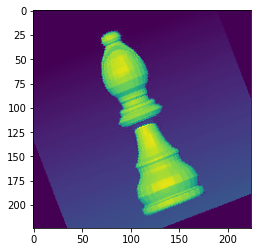

In [28]:
t = np.array(test_loader.dataset)
plt.imshow(np.array(t[ind][0][2]))

In [ ]:
img = cv2.imread(dataset.imgs[23][0])

In [ ]:
plt.imshow(img)

In [ ]:
img.shape